# The multiarmed bandit problem
We are tring to maximize the reward of the bandid problem or to minimize the regret of the problem.

In [44]:
!source env/bin/activate
# !pip install numpy
# !pip isntall pandas
# !pip install random
# !pip install math
# !pip install scipy
import env
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import bernoulli
from scipy.stats import beta
import matplotlib.pyplot as plt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.98114589]


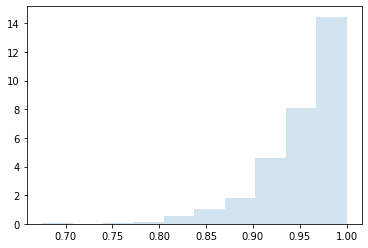

In [263]:
fig, ax = plt.subplots(1, 1)
r = beta(20, 1)
print(r.rvs(size=1))
ax.hist(r.rvs(size=1000), density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()


In [156]:
class Bandit():
    def createRewards(self,totalTime):
        """
        Function to create rewards base on the simulation time using bernoulli 
        distribution
        """
        rewardPercentage = 0.45
        lossPercentage = 0.55
        return list(bernoulli.rvs(rewardPercentage, lossPercentage, totalTime))


    def __init__(self,id,totalTime):
        """
        Initialize the bandids name, time of play and the range the rewards will
        get.
    
        """
        self.distrParameters = (1,1)
        self.id = id
        self.listCurrent = self.createRewards(totalTime)
        self.listPlayed = []
        # print(self.listCurrent)
  
        return None



    
    def nextstateBandit(self,timestamp):
        """
        Next state will give a spin the bandit and will give us
        a reward from the listCurrent. Also this reward will go to the listPLayed 
        states.

        """
        reward = self.listCurrent.pop(0)
        self.listPlayed.append(reward)
        return reward





In [202]:
"""
Auxilary functions for plotting
"""    

def plotBetaFunctions(listofBandits,time):
    """
    For each step plot the distributions of each bandit
    """
    fig , axs = plt.subplots(nrows=len(listofBandits),ncols=1, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
 

    for i in range(len(listofBandits)):
        id =  listofBandits[i].id
        pr = listofBandits[i].distrParameters
        r = beta.rvs(pr[0],pr[1],size=1000)
        axs[i].hist(r, density=True, histtype='stepfilled', alpha=0.2)
        fig.suptitle(f"Bandid {id} for time {time}")
        fig.show()

    return None

In [280]:
class Agent():
    """
    Initialize the agent. We determine the number of bandits, the total time of the
    simulation and the range of rewards they will give. Also we initialize the action 
    space and some functions for the rewards. Also we use the approach method in order 
    too compute whatever we want.

    actionState : (id, time, reward)

    """
    def __init__(self,totalTime,numOfBandits,approach):
        self.totalTime = int(totalTime)
        self.approach = approach
        self.numOfBandits = int(numOfBandits)
        self.actionState = []
        self.listOfBandits = []  
        for bandit in range(self.numOfBandits):
            self.listOfBandits.append(Bandit(bandit,self.totalTime))

        return None
        


    def countofAction(self,id):
        """
        Function which computes the count of action with 'id' == id
        """
        indicator = 0
        for i in self.actionState:
            if i[0] == id:
                indicator += 1
        return indicator


    def nextState(self,timestep,bandit):
        """
        Function where the agent goes to next stage :
            t -> t + 1

        We take as an input the bandit we will pull and the timestamp
        and we return the last action.
            
        """
        #we going to next state
        currentBandid = self.listOfBandits[bandit]
        currentBandidReward = currentBandid.nextstateBandit(timestep)

        if approach in ['bayesian','thompsonSampling']:
            if currentBandidReward == 0:
                currentBandid.distrParameters = (currentBandid.distrParameters[0]
                                                , currentBandid.distrParameters[1]+1) 

            else:
                currentBandid.distrParameters = (currentBandid.distrParameters[0]+1
                                                , currentBandid.distrParameters[1])




        # print(f"timestep {timestep} , reward {currentBandidReward}")
        self.actionState.append((bandit,timestep,currentBandidReward))
        return self.actionState[-1]


    def currentReward(self):
        """
        Function which culculated the reward at the last moment
        """
        reward = 0
        for i in self.actionState:
            reward += i[2]
        return reward


    def averageOfSampledRewards(self,id):
        """
        Cuclulates the average of sampled rewards for each bandit
        """
        upper = 0
        lower = 0
        for i in self.actionState:
            if id == i[0]:
                upper += i[2]
                lower += 1
        if lower == 0:
            return 0
        else:
            return upper/lower
    



    def regeretOFAction(self,id):
        """
        Regret of an action a is:

            D = v* - q(a)

        where :
            * v* is the maximum expected reward 
            * q(a) is the value of action a

        """
        #parameters
        V = 1
        q_a = self.averageOfSampledRewards(id)
        return V - q_a



    def actionValue(self,a):
        """
        Action value: The expected reward for action a
        """
        return True

    def randomSelection(self,timestep):
        """
        This function selects randomly a bandit and returns the new state to
        the action stages.

        """
        currentbanditId = random.randint(0,self.numOfBandits-1)
        currentBandid = self.listOfBandits[currentbanditId]
        currentBandidReward = currentBandid.nextstateBandit(timestep)
        if approach in ['bayesian','thompsonSampling']:
            if currentBandidReward == 0:
                currentBandid.distrParameters = (currentBandid.distrParameters[0]
                                                , currentBandid.distrParameters[1]+1) 

            else:
                currentBandid.distrParameters = (currentBandid.distrParameters[0]+1
                                                , currentBandid.distrParameters[1])

        state = (currentbanditId, timestep, currentBandidReward)
        self.actionState.append(state)
        return state

    def greedy(self,timestep):
        """
        Greedy function for the next state. At every steps it selectst the
        next bandit based on the bigger Average Sample Rewards

        """
        #we select our bandit
        maxReward = -1
        maxBandit = -1
        for i in self.listOfBandits:
            currentsampleReward = self.averageOfSampledRewards(i.id)
            if currentsampleReward > maxReward:
                maxReward = currentsampleReward
                maxBandit = i.id
        
        return self.nextState(timestep,maxBandit)



    def epsilonGreedy(self,timestep):
        """
        eGreedy:
            with propability 1-e selects greedy action
            with propability e selects a random action
        """
        epsilon = 0.1
        value = random.random()
        if value > epsilon:
            result = self.greedy(timestep)
        else:
            result = self.randomSelection(timestep)
        return result



    def uppercoefidenceboundValue(self,timestep,id):
        """
        Culculates the upper coefidence bound for the given id.

        """
        c = math.sqrt(2)
        if self.countofAction(id) > 0:
            return c*math.sqrt( math.log10(timestep) / self.countofAction(id) )
        else : 
            return 0

    def UpperConfidenceBounds(self,timestep):
        """
        Upper Confidence Bound:
        It is using a factor where it hepls to decide better.

        """
        #we select our bandit
        maxReward = 0
        maxBandit = 0
        upperBound = self.uppercoefidenceboundValue(timestep,0)

        for i in self.listOfBandits:
            upperBound = self.uppercoefidenceboundValue(timestep,i.id)
            currentsampleReward = self.averageOfSampledRewards(i.id) + upperBound
            # print(f"timestep {timestep} , reward {currentsampleReward}")
            if currentsampleReward > maxReward:
                maxReward = currentsampleReward
                maxBandit = i.id
        

        return self.nextState(timestep,maxBandit)




    def actionPreferences():
        pass




    def policySearch():
        pass


    def upperConfidenceBoundBayesian(self,time,id):
        """
        The ucb for the bayesian approach will be the standar deviation of the Beta 
         distribution multiplied with a constant.

            U(q) = c*sigma(Ut)

        """
        c = np.sqrt(2)
        pr = self.listOfBandits[id].distrParameters
        return c*beta(pr[0],pr[1]).var()



    def bayesianApproach(self,timestep):
        """
        Bayesian approach to the bandit problem :
            * For each action we think each value is in [0,1] equallly likely (prior ~ U(0,1))
            * The posterior is a Beta Distribution(xa,ya) where initially the xa=ya=1 and:
            xa <- xa + 1 , whene Rt = 0
            ya <- ya + 1 , where Rt = 1

        """

        #we select our bandit
        maxReward = 0
        maxBandit = 0

        for i in self.listOfBandits:
            upperBound = self.upperConfidenceBoundBayesian(timestep,i.id)
            currentsampleReward = self.averageOfSampledRewards(i.id) + upperBound
            # currentsampleReward = upperBound

            print(f"timestep {timestep} , reward {currentsampleReward}, bandit {i.id}")
            if currentsampleReward > maxReward:
                maxReward = currentsampleReward
                maxBandit = i.id
        
        return self.nextState(timestep,maxBandit)

         
    def thompsonPropability(self,id):
        """
        Function to culculates the Thompson variable to decide which
        bandit we are going to use next.

        """
        return beta.rvs(id[0],id[1],size=1)



    def thompsonSampling(self,timestep):
        """
        At Thompson Sampling we begin with the prior distribution beta(1,1) ~ Uniform
        Then randomly we select a number from the Beta from each bandit. If is 1 then we 
        update the upper bound else, we update the lower. For each timestep we follow the same
        procedure.

        """


        maxReward = 0
        maxBandit = 0

        for i in self.listOfBandits:
            thompsonValue = self.thompsonPropability(i.distrParameters)
            # print(f"timestep {timestep} , reward {thompsonValue}, bandit {i.id}")
            if thompsonValue > maxReward:
                maxReward = thompsonValue
                maxBandit = i.id
        
        return self.nextState(timestep,maxBandit)



        


    def nextStateAgent(self,timestep,approach):
        """
        Function which lead our agent to the next state.

        If is the first step of the agent we randomly select a bandit.

        Else:
            for each bandid we culculate the next step based on the approach we 
            want to examine.

        """
        
        if timestep == 0:
            return self.randomSelection(timestep)
        else:
            if self.approach == 'greedy':
                return self.greedy(timestep)

            if self.approach =='egreedy':
                return self.epsilonGreedy(timestep)
                        
            if self.approach == 'ucb':
                return self.UpperConfidenceBounds(timestep)
        
            if self.approach == 'bayesian':
                # plotBetaFunctions(self.listOfBandits,timestep)
                return self.bayesianApproach(timestep)

            if self.approach == 'thompsonSampling':
                return self.thompsonSampling(timestep)





In [285]:
#parameters
possibleApproaches = ['greedy','egreedy','ucb','bayesian']

totalTime = 100
bandits = 5
approach = 'thompsonSampling'
states = []



agent =  Agent(totalTime,bandits,approach)
for t in range(totalTime):
    states.append(agent.nextStateAgent(t,approach))
    
for i in states:
    print(i)
print(agent.currentReward())

(2, 0, 1)
(2, 1, 1)
(0, 2, 1)
(2, 3, 1)
(4, 4, 0)
(0, 5, 1)
(3, 6, 1)
(1, 7, 0)
(0, 8, 1)
(3, 9, 0)
(0, 10, 0)
(2, 11, 0)
(0, 12, 1)
(0, 13, 1)
(4, 14, 0)
(3, 15, 1)
(3, 16, 0)
(0, 17, 0)
(2, 18, 0)
(2, 19, 1)
(1, 20, 0)
(2, 21, 1)
(3, 22, 0)
(2, 23, 1)
(3, 24, 1)
(2, 25, 0)
(4, 26, 0)
(2, 27, 1)
(3, 28, 0)
(2, 29, 0)
(0, 30, 1)
(0, 31, 0)
(3, 32, 1)
(2, 33, 0)
(0, 34, 1)
(2, 35, 0)
(0, 36, 0)
(0, 37, 1)
(0, 38, 1)
(2, 39, 1)
(0, 40, 0)
(0, 41, 0)
(0, 42, 1)
(4, 43, 0)
(3, 44, 1)
(1, 45, 0)
(0, 46, 1)
(3, 47, 1)
(0, 48, 0)
(3, 49, 0)
(2, 50, 0)
(2, 51, 0)
(0, 52, 1)
(0, 53, 0)
(3, 54, 0)
(3, 55, 0)
(0, 56, 1)
(0, 57, 0)
(2, 58, 0)
(0, 59, 0)
(0, 60, 1)
(3, 61, 1)
(0, 62, 0)
(3, 63, 1)
(2, 64, 0)
(2, 65, 1)
(1, 66, 1)
(2, 67, 1)
(2, 68, 0)
(0, 69, 0)
(2, 70, 0)
(0, 71, 0)
(2, 72, 1)
(3, 73, 0)
(2, 74, 1)
(2, 75, 0)
(2, 76, 0)
(3, 77, 1)
(2, 78, 0)
(0, 79, 0)
(0, 80, 0)
(0, 81, 0)
(3, 82, 1)
(4, 83, 1)
(1, 84, 1)
(2, 85, 1)
(0, 86, 1)
(3, 87, 1)
(3, 88, 1)
(3, 89, 1)
(3, 90, 0)
(0, 91, 0